# 整数制約なし最適化問題: QUIO と HUIO

通常のイジング模型やQUBOでは変数は2値のバイナリ変数 $\sigma_i \in \{-1, +1\}$ または $x_i \in \{0, 1\}$ に限定されています。しかし、実際の最適化問題では整数値の変数を扱う必要がある場合が多くあります。

多くの場合、整数変数を含む問題はバイナリエンコードを用いて2値変数に変換してから解くことが行われます。しかし、この方法では変数の数が増加し、問題が複雑になってしまいます。

OpenJijでは、変数が整数値を取ることができる最適化問題を**直接解く**ことができます：

- **QUIO (Quadratic Unconstrained Integer Optimization)**: 2次以下の項のみを含む整数制約なし最適化問題
- **HUIO (Higher-order Unconstrained Integer Optimization)**: 高次の項も含む整数制約なし最適化問題

このチュートリアルでは、OpenJijの `sample_quio` および `sample_huio` メソッドを使って、これらの問題を解く方法を学びます。

## QUIO: 2次整数制約なし最適化問題

まず、2次以下の項のみを含む整数制約なし最適化問題（QUIO）から始めましょう。以下のようなエネルギー関数を考えます：

$$
H = c + \sum_i h_i z_i + \sum_{i<j} J_{ij} z_i z_j
$$

ここで、$z_i$ は整数変数で、各変数は指定された範囲 $[\text{lower}_i, \text{upper}_i]$ の整数値を取ることができます。

### 具体例：3変数の2次関数最適化

以下のような3変数の2次関数の最小化問題を考えてみましょう：

$$
H = 10 - 5z_1 - 3z_2 - 4z_3 + 2z_1z_2 + z_1z_3 + 1.5z_2z_3
$$

各変数の範囲：
- $z_1 \in [-2, 3]$
- $z_2 \in [-1, 4]$
- $z_3 \in [0, 5]$

この問題をOpenJijで解いてみましょう。

In [1]:
# 必要なライブラリのインストール
!pip install openjij numpy matplotlib

In [2]:
import openjij as oj
import numpy as np
import matplotlib.pyplot as plt
import time

# SASamplerを作成
sampler = oj.SASampler()

In [3]:
# QUIO問題の定義
# 相互作用の辞書：キーはタプル、値は係数
J = {
    (): 10,        # 定数項
    (1,): -5,      # z1の線形項
    (2,): -3,      # z2の線形項
    (3,): -4,      # z3の線形項
    (1, 2): 2,     # z1*z2の2次項
    (1, 3): 1,     # z1*z3の2次項
    (2, 3): 1.5    # z2*z3の2次項
}

# 変数の範囲を指定
bound_list_quio = {
    1: (-2, 3),  # z1は-2から3の整数
    2: (-1, 4),  # z2は-1から4の整数
    3: (0, 5)    # z3は0から5の整数
}

print("QUIO問題:")
print(f"相互作用: {J}")
print(f"変数の範囲: {bound_list_quio}")

QUIO問題:
相互作用: {(): 10, (1,): -5, (2,): -3, (3,): -4, (1, 2): 2, (1, 3): 1, (2, 3): 1.5}
変数の範囲: {1: (-2, 3), 2: (-1, 4), 3: (0, 5)}


In [4]:
# sample_quioメソッドでQUIO問題を解く
response_quio = sampler.sample_quio(
    J=J,
    bound_list=bound_list_quio,
    num_sweeps=1000,
    num_reads=10,
    num_threads=4,  # 並列サンプリング（macOS/Linuxのみ）
    seed=12345
)

# 最適解を表示
best_solution = response_quio.first
print(f"最適解: {best_solution.sample}")
print(f"最小エネルギー: {best_solution.energy:.3f}")

最適解: {1: 3, 2: -1, 3: 5}
最小エネルギー: -20.500


## HUIO: 高次整数制約なし最適化問題

次に、高次の項も含む整数制約なし最適化問題（HUIO）を解いてみましょう。3次以上の項も扱うことができます：

$$
H = c + \sum_i h_i z_i + \sum_{i<j} J_{ij} z_i z_j + \sum_{i<j<k} K_{ijk} z_i z_j z_k + \cdots
$$

### 具体例：3変数の3次関数最適化

以下のような3変数の3次関数の最小化問題を考えてみましょう：

$$
H = 5 - 8z_1 - 6z_2 - 4z_3 + 3z_1z_2 + 2z_1z_3 + 2.5z_2z_3 + 0.5z_1z_2z_3
$$

各変数の範囲：
- $z_1 \in [-1, 2]$
- $z_2 \in [-2, 1]$
- $z_3 \in [1, 4]$

3次項 $z_1z_2z_3$ により、変数間の高次の相互作用を表現しています。

In [5]:
# HUIO問題の定義
J = {
    (): 5,         # 定数項
    (1,): -8,      # z1の線形項
    (2,): -6,      # z2の線形項
    (3,): -4,      # z3の線形項
    (1, 2): 3,     # z1*z2の2次項
    (1, 3): 2,     # z1*z3の2次項
    (2, 3): 2.5,   # z2*z3の2次項
    (1, 2, 3): 0.5 # z1*z2*z3の3次項
}

# 変数の範囲を指定
bound_list_huio = {
    1: (-1, 2),  # z1は-1から2の整数
    2: (-2, 1),  # z2は-2から1の整数
    3: (1, 4)    # z3は1から4の整数
}

print("HUIO問題:")
print(f"相互作用: {J}")
print(f"変数の範囲: {bound_list_huio}")

HUIO問題:
相互作用: {(): 5, (1,): -8, (2,): -6, (3,): -4, (1, 2): 3, (1, 3): 2, (2, 3): 2.5, (1, 2, 3): 0.5}
変数の範囲: {1: (-1, 2), 2: (-2, 1), 3: (1, 4)}


In [6]:
# sample_huioメソッドでHUIO問題を解く
response_huio = sampler.sample_huio(
    J=J,
    bound_list=bound_list_huio,
    num_sweeps=1000,
    num_reads=10,
    num_threads=4,  # 並列サンプリング（macOS/Linuxのみ）
    seed=12345
)

# 最適解を表示
best_solution = response_huio.first
print(f"最適解: {best_solution.sample}")
print(f"最小エネルギー: {best_solution.energy:.3f}")

最適解: {1: 2, 2: -2, 3: 4}
最小エネルギー: -39.000


## 解の可視化と比較

ここでは、より実践的な問題を使ってQUIOとHUIOの性能を可視化し比較してみます。シードを固定したランダムなグラフを目的関数として、求解時間と目的関数値の関係、およびエネルギー分布を調べます。

In [7]:
import random

def generate_random_interactions(N, num_interactions, order, seed=1, coeff_range=(-1.0, 1.0)):
    J = {}
    engine = random.Random(seed)
    n_range = range(N)
    for _ in range(num_interactions):
        chosen_indices = engine.choices(n_range, k=order)
        canonical_indices_tuple = tuple(sorted(chosen_indices))
        J[canonical_indices_tuple] = engine.uniform(*coeff_range)/num_interactions
    
    return J

# ランダムなQUIO問題の係数を生成
N = 1000  # 変数の数
num_interactions = 100000  # 相互作用の数
J_quio_random = generate_random_interactions(N, num_interactions, order=2)

bound_list = {
    i: (-5, 5) for i in range(N)
}

print(f"QUIO問題: {len(J_quio_random)}個の項")

QUIO問題: 90711個の項


In [8]:
# ランダムなHUIO問題の係数を生成（3次項も含める）
J_huio_random = generate_random_interactions(N, num_interactions, order=4, seed=42)

print(f"HUIO問題: {len(J_huio_random)}個の項")

HUIO問題: 100000個の項


In [9]:
# 異なるsweep数での性能測定
sweep_values = [3, 5, 10, 20, 50, 100, 200]
quio_results = []
huio_results = []

print("求解時間と目的関数値の測定中...")

for sweeps in sweep_values:
    # QUIO問題の求解
    response_q = sampler.sample_quio(
        J=J_quio_random,
        bound_list=bound_list,
        num_sweeps=sweeps,
        num_reads=50,
        seed=42,
        num_threads=4  # 並列サンプリング（macOS/Linuxのみ）
    )
    quio_time = response_q.info["time"]["total"]
    quio_mean = np.mean(response_q.energies)
    quio_std = np.std(response_q.energies)
    quio_results.append((sweeps, quio_time, quio_mean, quio_std))

    # HUIO問題の求解
    response_h = sampler.sample_huio(
        J=J_huio_random,
        bound_list=bound_list,
        num_sweeps=sweeps,
        num_reads=50,
        seed=42,
        num_threads=4  # 並列サンプリング（macOS/Linuxのみ）
    )
    huio_time = response_h.info["time"]["total"]
    huio_mean = np.mean(response_h.energies)
    huio_std = np.std(response_h.energies)
    huio_results.append((sweeps, huio_time, huio_mean, huio_std))

print("測定完了")

求解時間と目的関数値の測定中...
測定完了


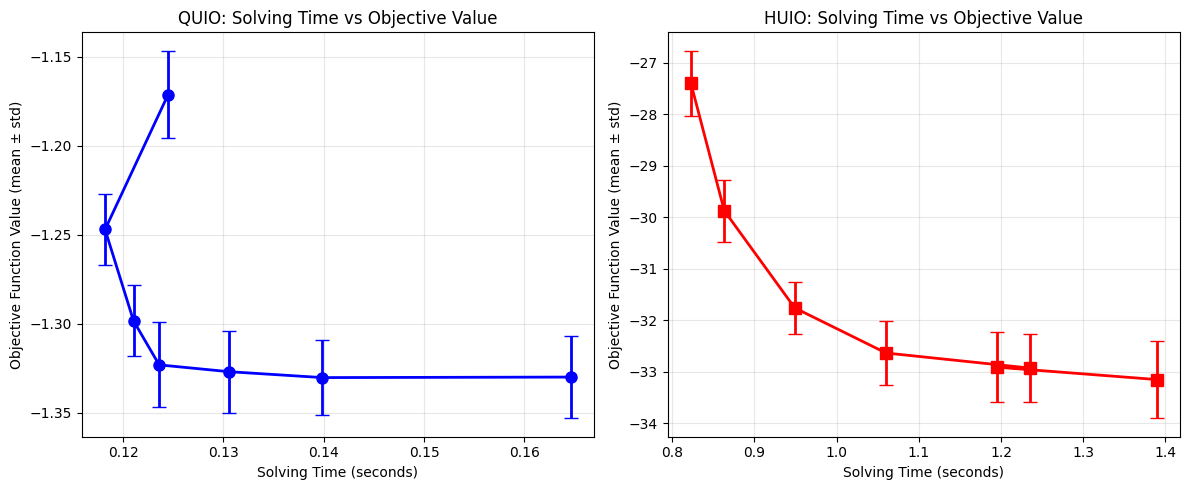

In [10]:
# 求解時間と目的関数値の可視化
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# 横軸：求解時間、縦軸：目的関数値
quio_times = [result[1] for result in quio_results]
quio_energies = [result[2] for result in quio_results]
quio_stds = [result[3] for result in quio_results]
huio_times = [result[1] for result in huio_results]
huio_energies = [result[2] for result in huio_results]
huio_stds = [result[3] for result in huio_results]

ax1.errorbar(quio_times, quio_energies, yerr=quio_stds, fmt='bo-', linewidth=2, markersize=8, capsize=5)
ax1.set_xlabel('Solving Time (seconds)')
ax1.set_ylabel('Objective Function Value (mean ± std)')
ax1.set_title('QUIO: Solving Time vs Objective Value')
ax1.grid(True, alpha=0.3)

ax2.errorbar(huio_times, huio_energies, yerr=huio_stds, fmt='rs-', linewidth=2, markersize=8, capsize=5)
ax2.set_xlabel('Solving Time (seconds)')
ax2.set_ylabel('Objective Function Value (mean ± std)')
ax2.set_title('HUIO: Solving Time vs Objective Value')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

エネルギー分布の測定中...


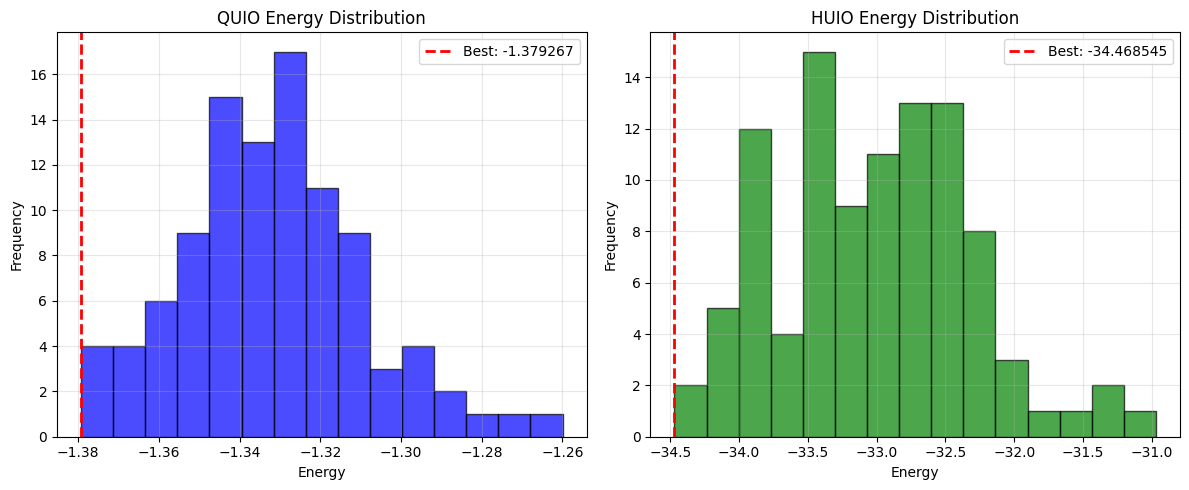

QUIO最良解エネルギー: -1.379267
HUIO最良解エネルギー: -34.468545
エネルギー改善: 33.089278


In [11]:
# エネルギー分布の測定
print("エネルギー分布の測定中...")

# 多数の解を取得してエネルギー分布を調べる
response_quio_dist = sampler.sample_quio(
    J=J_quio_random,
    bound_list=bound_list,
    num_sweeps=1000,
    num_reads=100,
    seed=42,
    num_threads=4  # 並列サンプリング（macOS/Linuxのみ）
)

response_huio_dist = sampler.sample_huio(
    J=J_huio_random,
    bound_list=bound_list,
    num_sweeps=1000,
    num_reads=100,
    seed=42,
    num_threads=4  # 並列サンプリング（macOS/Linuxのみ）
)

# エネルギー分布の可視化
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# QUIO エネルギー分布
energies_quio = response_quio_dist.data_vectors['energy']
ax1.hist(energies_quio, bins=15, alpha=0.7, color='blue', edgecolor='black')
ax1.axvline(np.min(energies_quio), color='red', linestyle='--', linewidth=2, 
           label=f'Best: {np.min(energies_quio):.6f}')
ax1.set_xlabel('Energy')
ax1.set_ylabel('Frequency')
ax1.set_title('QUIO Energy Distribution')
ax1.legend()
ax1.grid(True, alpha=0.3)

# HUIO エネルギー分布
energies_huio = response_huio_dist.data_vectors['energy']
ax2.hist(energies_huio, bins=15, alpha=0.7, color='green', edgecolor='black')
ax2.axvline(np.min(energies_huio), color='red', linestyle='--', linewidth=2, 
           label=f'Best: {np.min(energies_huio):.6f}')
ax2.set_xlabel('Energy')
ax2.set_ylabel('Frequency')
ax2.set_title('HUIO Energy Distribution')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"QUIO最良解エネルギー: {np.min(energies_quio):.6f}")
print(f"HUIO最良解エネルギー: {np.min(energies_huio):.6f}")
print(f"エネルギー改善: {(np.min(energies_quio) - np.min(energies_huio)):.6f}")

## まとめ

このチュートリアルでは、OpenJijを使った整数制約なし最適化問題の解法を学びました：

### QUIO (Quadratic Unconstrained Integer Optimization)
- 2次以下の項のみを含む整数最適化問題
- `sample_quio` メソッドを使用
- 線形項と2次項で構成される目的関数

### HUIO (Higher-order Unconstrained Integer Optimization)
- 高次の項も含む整数最適化問題
- `sample_huio` メソッドを使用
- より複雑な相互作用を表現可能
- 3次以上の高次項を含む目的関数

### 重要なポイント
1. **変数の範囲指定**: `bound_list` で各変数の取りうる整数値の範囲を指定
2. **相互作用の表現**: 辞書形式でタプルをキーとして相互作用を定義
3. **パラメータ調整**: `num_sweeps`, `num_reads` 等のパラメータで最適化性能を調整

これらの手法により、バイナリ変数では表現困難な整数最適化問題を効率的に解くことができます。